In [2]:

from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shap
from statsmodels import robust
import time


c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [89]:
data = pd.read_csv('../data/cumulative_2022.04.28_05.30.33.csv', header=53)
data.head()


kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0           -81.0      4.467           0.064          -0.096     0.927   
1           -81.0      4.467           0.064          -0.096     0.927   
2          -176.0      4.544           0.044          -0.176     0.868   
3          -174.0      4.564           0.053          -0.168     0.791   
4          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 49 columns]

In [90]:
# Pop the columns:

to_pop = ["kepoi_name", "kepler_name", "koi_teq_err1",
          "koi_teq_err2", "koi_tce_delivname"]

for col in to_pop:
    data.pop(col)

# Numerische Werte:
koi_disposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2}
data["koi_disposition"] = data["koi_disposition"].replace(
    koi_disposition_dict)

koi_pdisposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1}
data["koi_pdisposition"] = data["koi_pdisposition"].replace(
    koi_pdisposition_dict)
data.head()


kepid  koi_disposition  koi_pdisposition  koi_score  koi_fpflag_nt  \
0  10797460                2                 1      1.000              0   
1  10797460                2                 1      0.969              0   
2  10811496                1                 1      0.000              0   
3  10848459                0                 0      0.000              0   
4  10854555                2                 1      1.000              0   

   koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  \
0              0              0              0    9.488036     2.775000e-05   
1              0              0              0   54.418383     2.479000e-04   
2              0              0              0   19.899140     1.494000e-05   
3              1              0              0    1.736952     2.630000e-07   
4              0              0              0    2.525592     3.761000e-06   

   ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0  ...           -81.0      4.467           0.064          -0.096     0.927   
1  ...           -81.0      4.467           0.064          -0.096     0.927   
2  ...          -176.0      4.544           0.044          -0.176     0.868   
3  ...          -174.0      4.564           0.053          -0.168     0.791   
4  ...          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 44 columns]

In [91]:
# Testen, ob Imputing Werte verfälscht.
#data = data[data['koi_score'].notna()]
#for column in data:
#    print(data[column][data[column].isna()])
print(data.shape)
data.isna().sum()


(9564, 44)


kepid                   0
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad    

In [92]:
number_of_nan = data.isna().sum().sum()
number_of_values = np.shape(data)[0]*np.shape(data)[1]
ratio_nan_to_numbers = number_of_nan/number_of_values
print(f"Insgesamt gibt es {data.isna().sum().sum()} NaN-Werte")
print(
    f"Anteil der NaN-Werte an Allen Werten = {ratio_nan_to_numbers}")
print(f"(Also sollten dieser Anteil an Werten beim Imputing-Test durch NaNs ersetzt werden.")


Insgesamt gibt es 13813 NaN-Werte
Anteil der NaN-Werte an Allen Werten = 0.03282432226911524
(Also sollten dieser Anteil an Werten beim Imputing-Test durch NaNs ersetzt werden.


In [93]:
print(data.shape)
data_imptest = data.dropna()
print(data_imptest.shape)
number_of_values_imptest = np.shape(data_imptest)[0]*np.shape(data_imptest)[1]
values_to_remove = number_of_values_imptest*ratio_nan_to_numbers
#data_imptest.isna().sum()
print(
    f"Es sollten {values_to_remove} Werte im Imputing-Test-Datensatz durch NaN ersetzt werden.")


(9564, 44)
(7803, 44)
Es sollten 11269.640213299874 Werte im Imputing-Test-Datensatz durch NaN ersetzt werden.


In [94]:
x_original = data_imptest.drop(['koi_disposition'], axis=1)
y = data_imptest['koi_disposition']
x = x_original.copy()
print(x_original.shape)
type(x_original)
#x.iloc[0:10,0:10]


(7803, 43)


pandas.core.frame.DataFrame

In [95]:
remove_n = int(round(values_to_remove))
# Array mit Länge remove_n, gefüllt mit zufälligen Ganzzahlen zwischen 0 und der Anzahl der Zeilen
rows = np.random.randint(0,x.shape[0],size=remove_n)
# Array mit Länge remove_n, gefüllt mit zufälligen Ganzzahlen zwischen 0 und der Anzahl der Spalten
cols = np.random.randint(0,x.shape[1],size=remove_n)


In [96]:
print(x.shape)
for ri, ci in list(zip(rows, cols)):
    #print("x[ri, ci].shape =", x[ri, ci].shape)
    #print(x[ri,ci])
    #print("ri =", ri, "ci =", ci)
    x.iloc[ri,ci] = np.nan
    #print(x[ri, ci])

print(x.shape)


(7803, 43)
(7803, 43)


In [97]:
print(x.shape)
print(y.shape)
print(f"{np.count_nonzero(np.isnan(x))} von {x.size} Werten fehlen")

(7803, 43)
(7803,)
11076 von 335529 Werten fehlen


In [98]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=45)



In [99]:
print(f"{np.count_nonzero(np.isnan(x_train))} von {x_train.size} Werten im Trainingsdatensatz fehlen")
print(f"{np.count_nonzero(np.isnan(x_test))} von {x_test.size} Werten im Testdatensatz fehlen")


7449 von 224804 Werten im Trainingsdatensatz fehlen
3627 von 110725 Werten im Testdatensatz fehlen


In [100]:
mean = np.mean(x_train, axis=0)
mean


kepid                7.680599e+06
koi_pdisposition     5.191051e-01
koi_score            4.882082e-01
koi_fpflag_nt        1.870688e-01
koi_fpflag_ss        2.682540e-01
koi_fpflag_co        2.198891e-01
koi_fpflag_ec        1.319115e-01
koi_period           3.627106e+01
koi_period_err1      9.035938e-04
koi_period_err2     -9.003968e-04
koi_time0bk          1.575051e+02
koi_time0bk_err1     7.549633e-03
koi_time0bk_err2    -7.480963e-03
koi_impact           6.141271e-01
koi_impact_err1      2.202210e+00
koi_impact_err2     -2.873515e-01
koi_duration         5.353705e+00
koi_duration_err1    2.474873e-01
koi_duration_err2   -2.474794e-01
koi_depth            2.613017e+04
koi_depth_err1       6.482479e+01
koi_depth_err2      -6.508268e+01
koi_prad             2.958229e+01
koi_prad_err1        7.416846e+00
koi_prad_err2       -8.223409e+00
koi_teq              1.135930e+03
koi_insol            6.712987e+03
koi_insol_err1       3.057235e+03
koi_insol_err2      -3.690540e+03
koi_model_snr 

In [101]:
#print(x_train[:20])
knn_imputer = KNNImputer()
knn_imputer.fit(x_train)
x_train = knn_imputer.transform(x_train)
x_test = knn_imputer.transform(x_test)
#x_train[:20]


In [102]:
print(f"{np.count_nonzero(np.isnan(x_train))} von {x_train.size} Werten im Trainingsdatensatz fehlen")
print(f"{np.count_nonzero(np.isnan(x_test))} von {x_test.size} Werten im Testdatensatz fehlen")


0 von 224804 Werten im Trainingsdatensatz fehlen
0 von 110725 Werten im Testdatensatz fehlen


In [108]:
mean_squared_error(knn_imputer.transform(x),x_original)

c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


6485793464.908249

c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was f

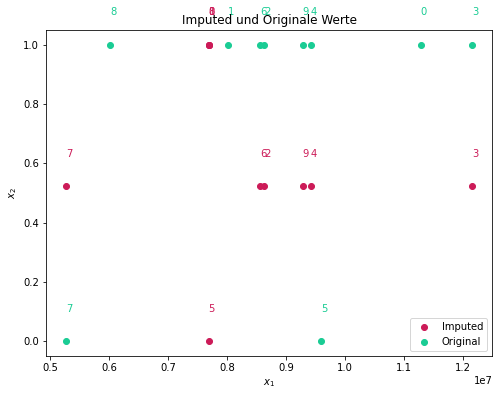

In [105]:
plt.figure(figsize=(8, 6))
label_imputed, label_original = "", ""
for i in range(10):
    # Plot Labels nur einmal
    if i == 9:
        label_imputed = "Imputed"
        label_original = "Original"

    # Errechne die fehlenden Werte
    x1, x2 = imputer.transform(x)[rows[np.where(cols <= 1)][i], :1], imputer.transform(x)[rows[np.where(cols <= 1)][i], 1:2]

    # Plotte die Imputed Werte und fortlaufende Nummer
    plt.scatter(x1, x2, c="#CC1B58", label=label_imputed)
    plt.text(x1-0.03, x2+0.1, str(i), c="#CC1B58")

    # Plotte die originalen Werte und fortlaufende Nummmer
    plt.scatter(x_original.iloc[rows[np.where(cols <= 1)][i], :1], x_original.iloc[rows[np.where(cols <= 1)][i], 1:2], c="#1ACC94", label=label_original)
    plt.text(x_original.iloc[rows[np.where(cols <= 1)][i], :1]-0.03,
             x_original.iloc[rows[np.where(cols <= 1)][i], 1:2]+0.1, str(i), c="#1ACC94")

# Plot beschreiben
#plt.xlim(np.min(x_original.iloc[:, :1]), np.max(x_original.iloc[:, :1]))
#plt.ylim(np.min(x_original.iloc[:, 1:2]), np.max(x_original.iloc[:, 1:2]))
plt.title("Imputed und Originale Werte")
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


In [106]:
x_original.iloc[rows[np.where(cols <= 1)][0:2], 40:42]


ra        dec
3511  284.56689  49.012550
3328  287.43918  43.832088

c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Users\Marco\Documents\GitHub\Kepler-Exoplaneten-ML-Projekt\.venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

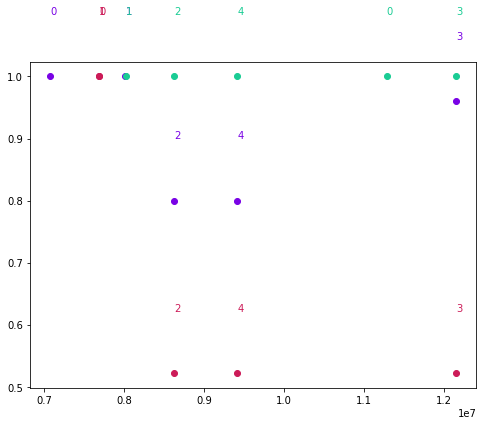

In [107]:
knn_imputer = KNNImputer()
knn_imputer.fit(x_train)
x_train = knn_imputer.transform(x_train)
x_test = knn_imputer.transform(x_test)

plt.figure(figsize=(8, 6))
label_imputed, label_original, label_knn_imputed = "", "", ""
for i in range(5):
    # Plot Labels nur einmal
    if i == 4:
        label_imputed = "Imputed"
        label_knn_imputed = "Knn Imputed"
        label_original = "Original"

    # Errechne die fehlenden Werte
    x1, x2 = imputer.transform(x)[rows[np.where(cols <= 1)][i], :1], imputer.transform(x)[
        rows[np.where(cols <= 1)][i], 1:2]

    # Plotte die Imputed Werte und fortlaufende Nummer
    plt.scatter(x1, x2, c="#CC1B58", label=label_imputed)
    plt.text(x1-0.03, x2+0.1, str(i), c="#CC1B58")

    # Errechne die fehlenden Werte
    knnx1, knnx2 = knn_imputer.transform(x)[rows[np.where(
        cols <= 1)][i], :1], knn_imputer.transform(x)[rows[np.where(cols <= 1)][i], 1:2]

    # Plotte die Imputed Werte und fortlaufende Nummer
    plt.scatter(knnx1, knnx2, c="#7902E5", label=label_knn_imputed)
    plt.text(knnx1-0.03, knnx2+0.1, str(i), c="#7902E5")

    # Plotte die originalen Werte und fortlaufende Nummmder
    plt.scatter(x_original.iloc[rows[np.where(cols <= 1)][i], :1], x_original.iloc[rows[np.where(
        cols <= 1)][i], 1:2], c="#1ACC94", label=label_original)
    plt.text(x_original.iloc[rows[np.where(cols <= 1)][i], :1]-0.03,
             x_original.iloc[rows[np.where(cols <= 1)][i], 1:2]+0.1, str(i), c="#1ACC94")

# Plot beschreiben
plt.xlim(np.min(x_original.iloc[:, :1]), np.max(x_original.iloc[:, :1]))
plt.ylim(np.min(x_original.iloc[:, 1:2]), np.max(x_original.iloc[:, 1:2]))
plt.title("Imputierte und originale Werte")
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


In [3]:

from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shap
from statsmodels import robust
import time




In [51]:
data = pd.read_csv('../data/cumulative.csv')


# Entfernung von übeflüssigen Spalten ohne Informationsgehalt:
# Spalten mit "id" oder "name" im Namen enthalten nur Bezeichnungen. Die beiden "koi_teq_err"-
# Spalten sind leer.

to_pop = ["rowid", "kepid", "kepoi_name", "kepler_name",
          "koi_teq_err1", "koi_teq_err2", "koi_tce_delivname"]

for col in to_pop:
    data.pop(col)

# Umwandelung von Ordinalwerten in numerische Werte:

koi_disposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2}
data["koi_disposition"] = data["koi_disposition"].replace(koi_disposition_dict)

koi_pdisposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1}
data["koi_pdisposition"] = data["koi_pdisposition"].replace(
    koi_pdisposition_dict)


# Ersetzung fehlender Werte durch imputierte Werte

knn_imputer = KNNImputer()

for column in data:

    data[column] = knn_imputer.fit_transform(
        data[column].to_numpy().reshape(-1, 1))
data.head()


koi_disposition  koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  \
0              2.0               1.0      1.000            0.0            0.0   
1              2.0               1.0      0.969            0.0            0.0   
2              0.0               0.0      0.000            0.0            1.0   
3              0.0               0.0      0.000            0.0            1.0   
4              2.0               1.0      1.000            0.0            0.0   

   koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  koi_period_err2  \
0            0.0            0.0    9.488036     2.775000e-05    -2.775000e-05   
1            0.0            0.0   54.418383     2.479000e-04    -2.479000e-04   
2            0.0            0.0   19.899140     1.494000e-05    -1.494000e-05   
3            0.0            0.0    1.736952     2.630000e-07    -2.630000e-07   
4            0.0            0.0    2.525592     3.761000e-06    -3.761000e-06   

   ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0  ...           -81.0      4.467           0.064          -0.096     0.927   
1  ...           -81.0      4.467           0.064          -0.096     0.927   
2  ...          -176.0      4.544           0.044          -0.176     0.868   
3  ...          -174.0      4.564           0.053          -0.168     0.791   
4  ...          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 43 columns]

   rowid  koi_disposition  koi_pdisposition  koi_score  koi_fpflag_nt  \
0    1.0              2.0               1.0      1.000            0.0   
1    2.0              2.0               1.0      0.969            0.0   
2    3.0              0.0               0.0      0.000            0.0   
3    4.0              0.0               0.0      0.000            0.0   
4    5.0              2.0               1.0      1.000            0.0   

   koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  \
0            0.0            0.0            0.0    9.488036     2.775000e-05   
1            0.0            0.0            0.0   54.418383     2.479000e-04   
2            1.0            0.0            0.0   19.899140     1.494000e-05   
3            1.0            0.0            0.0    1.736952     2.630000e-07   
4            0.0            0.0            0.0    2.525592     3.761000e-06   

   ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0  ... 

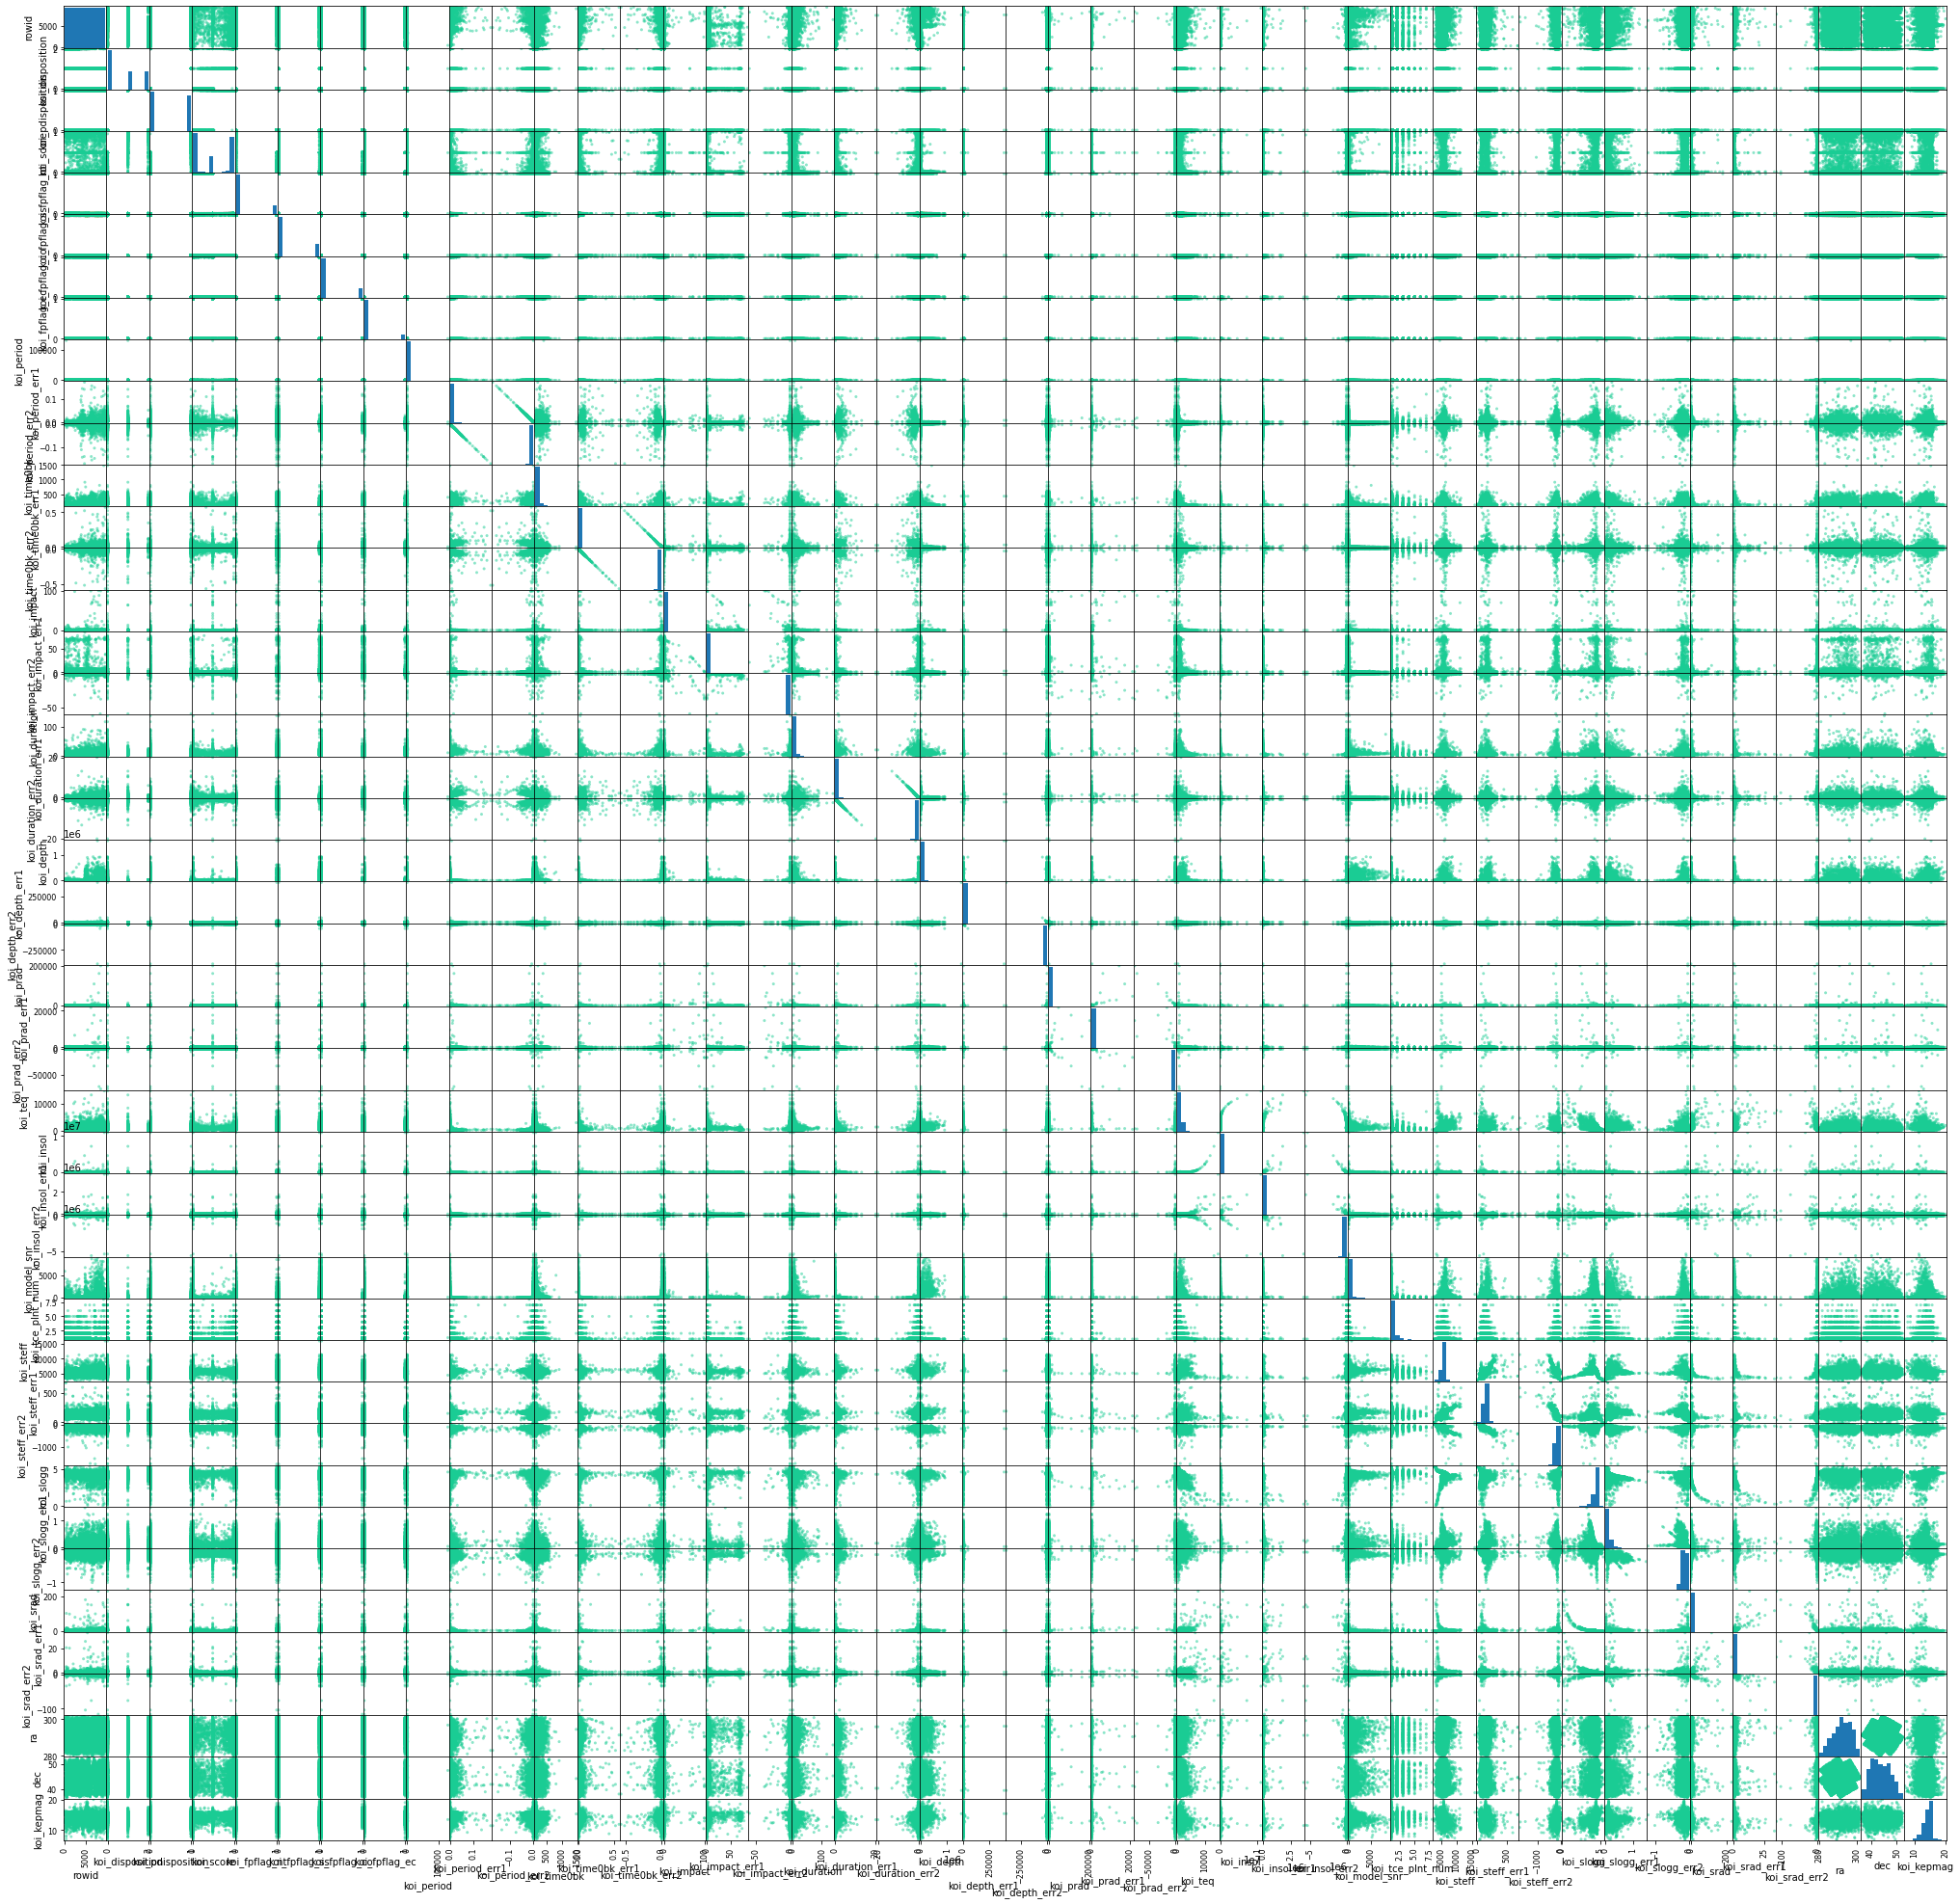

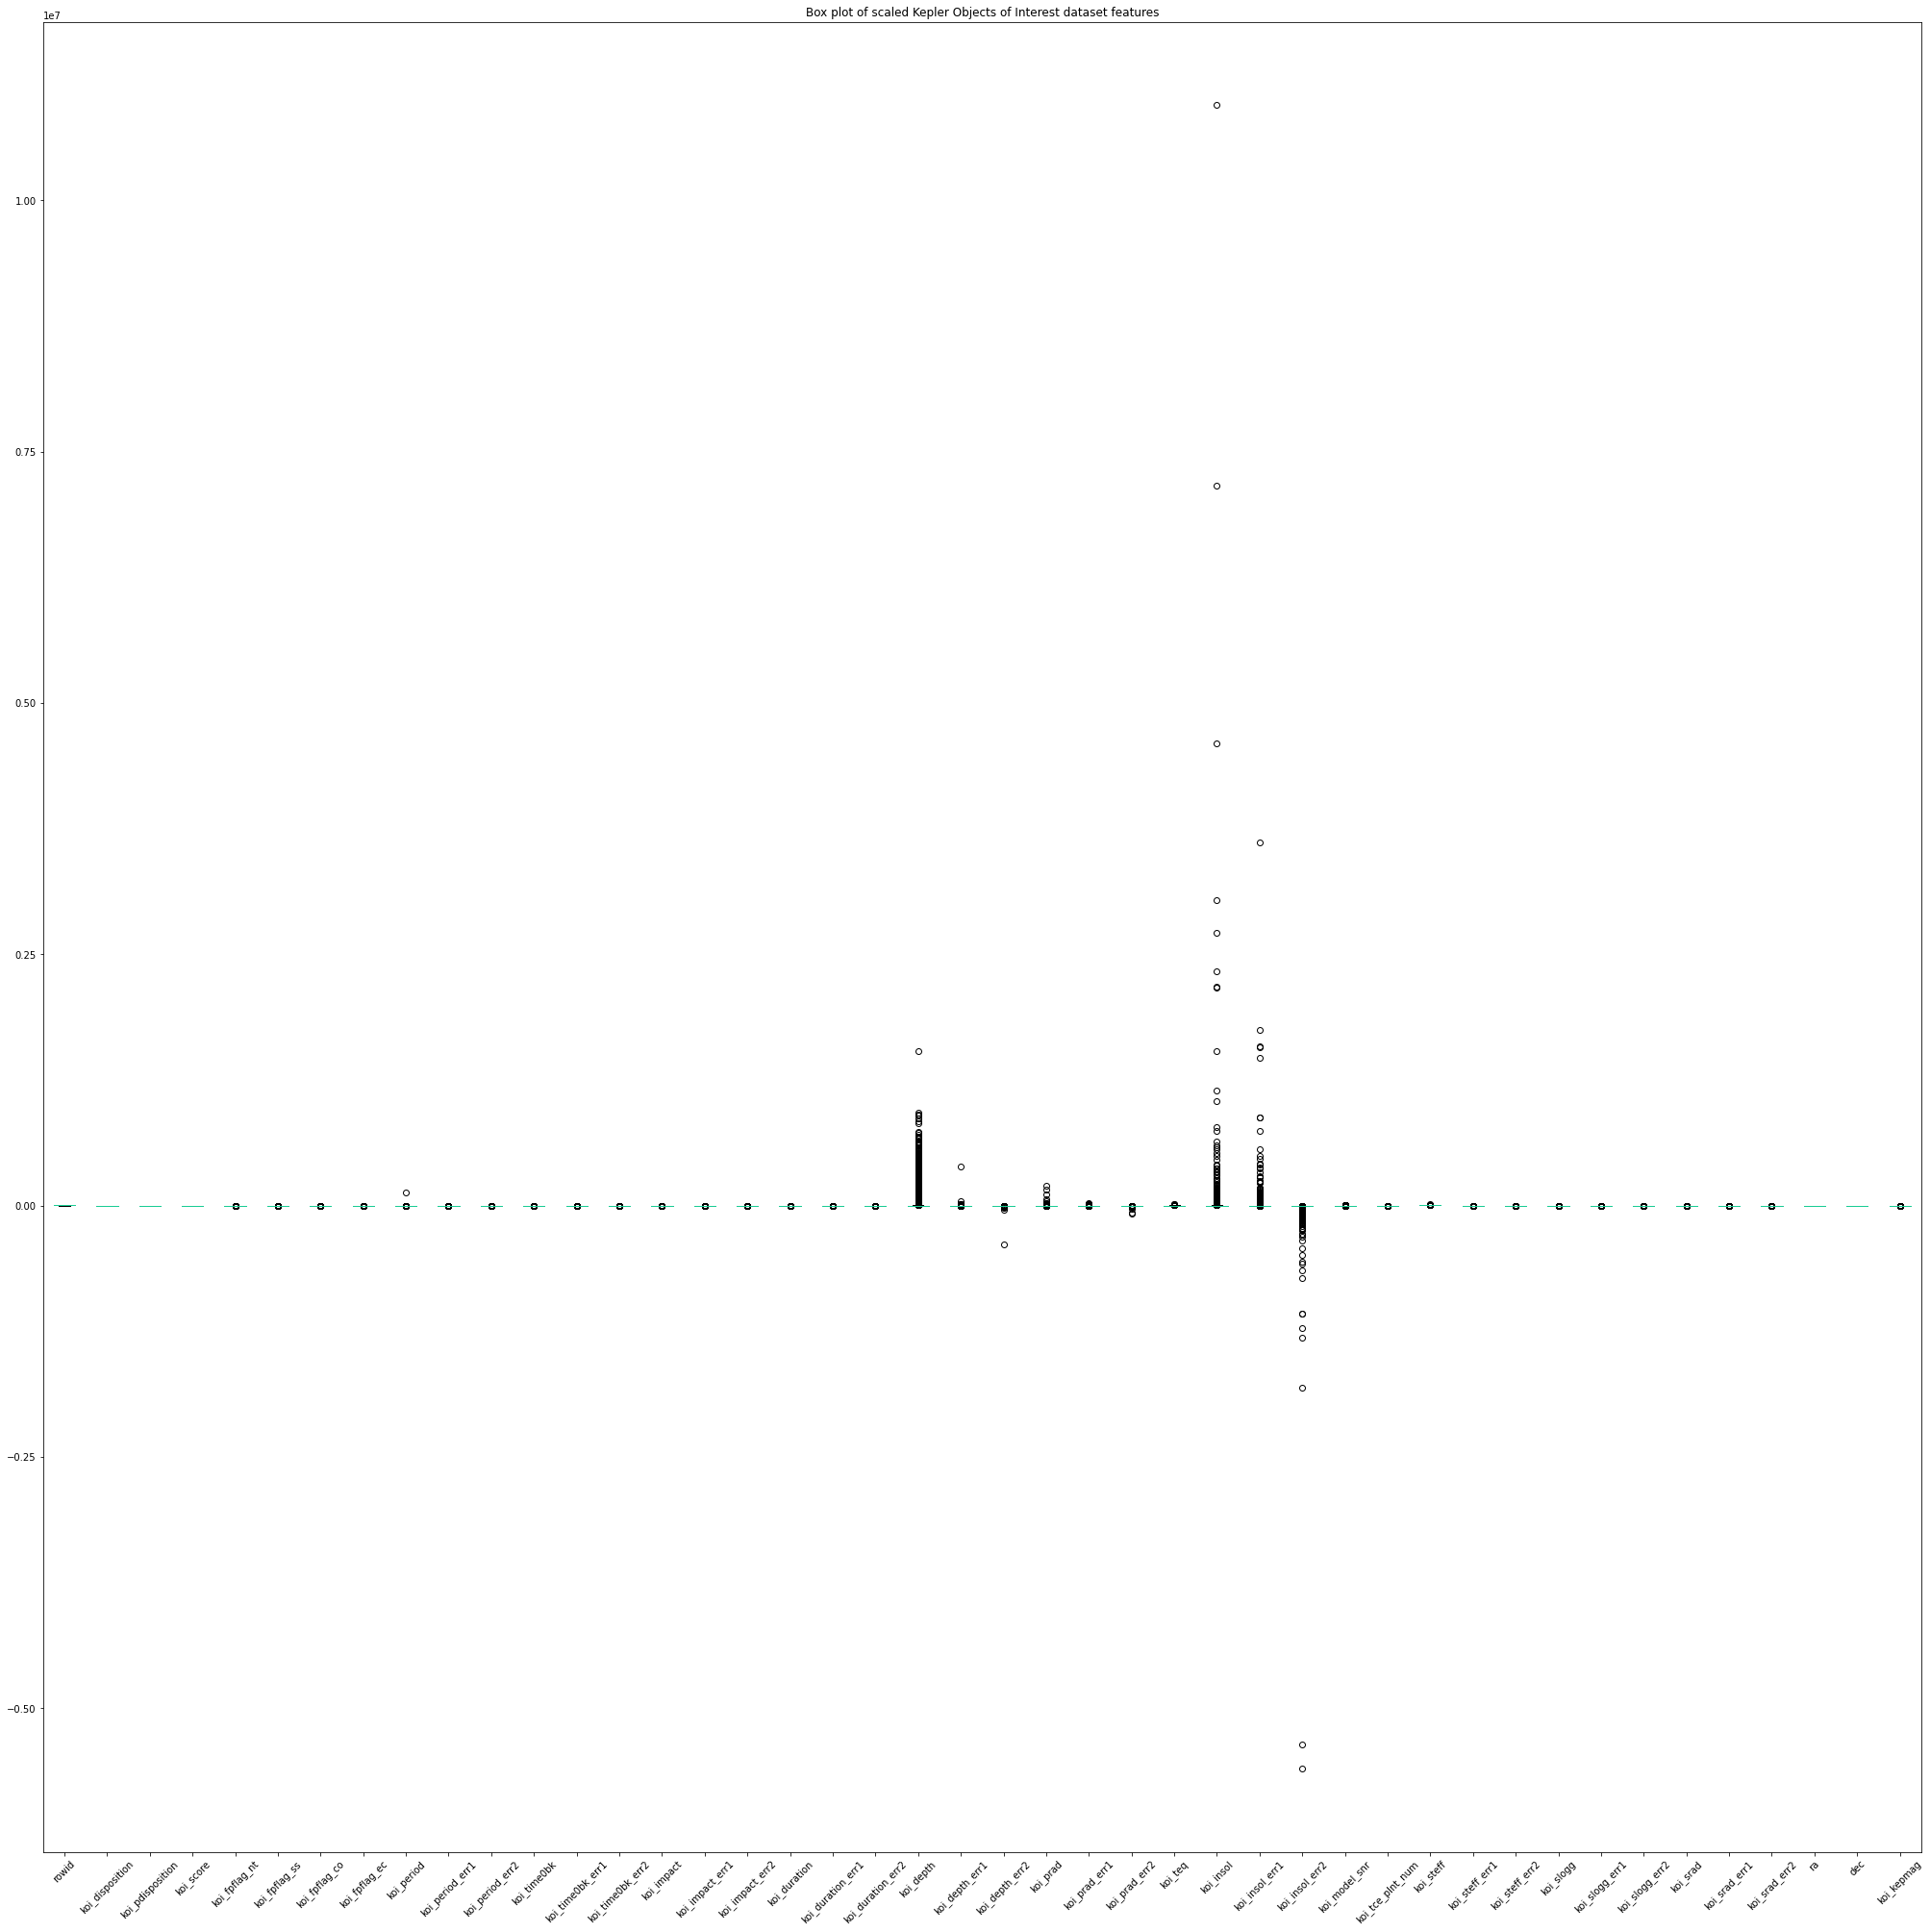

In [9]:



# Korrelationsmatrix erstellen

fig = plt.figure(figsize=(35, 35), dpi=300)
plt.title("Correlation heatmap of Kepler Objects of Interest dataset features")
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.savefig('../data/figures/heatmap.png')


# Streudiagrammsmatrix erstellen
plt.title("Scatter plot matrix of Kepler Objects of Interest dataset features")
pd.plotting.scatter_matrix(data, figsize=(35, 35), c="#1ACC94")
plt.savefig('../data/figures/scatter_matrix.png')


# Kastengrafik erstellen
# Werte skalieren um die Kastengrafik darstellen zu können.



fig = plt.figure(figsize=(35, 35))
plt.title("Box plot of scaled Kepler Objects of Interest dataset features")
plt.boxplot(data, labels=data.columns, medianprops=dict(color="#1ACC94"))
plt.xticks(rotation=45)
plt.savefig('../data/figures/boxplot.png')
plt.show()


In [52]:
data_scaled = data.copy()





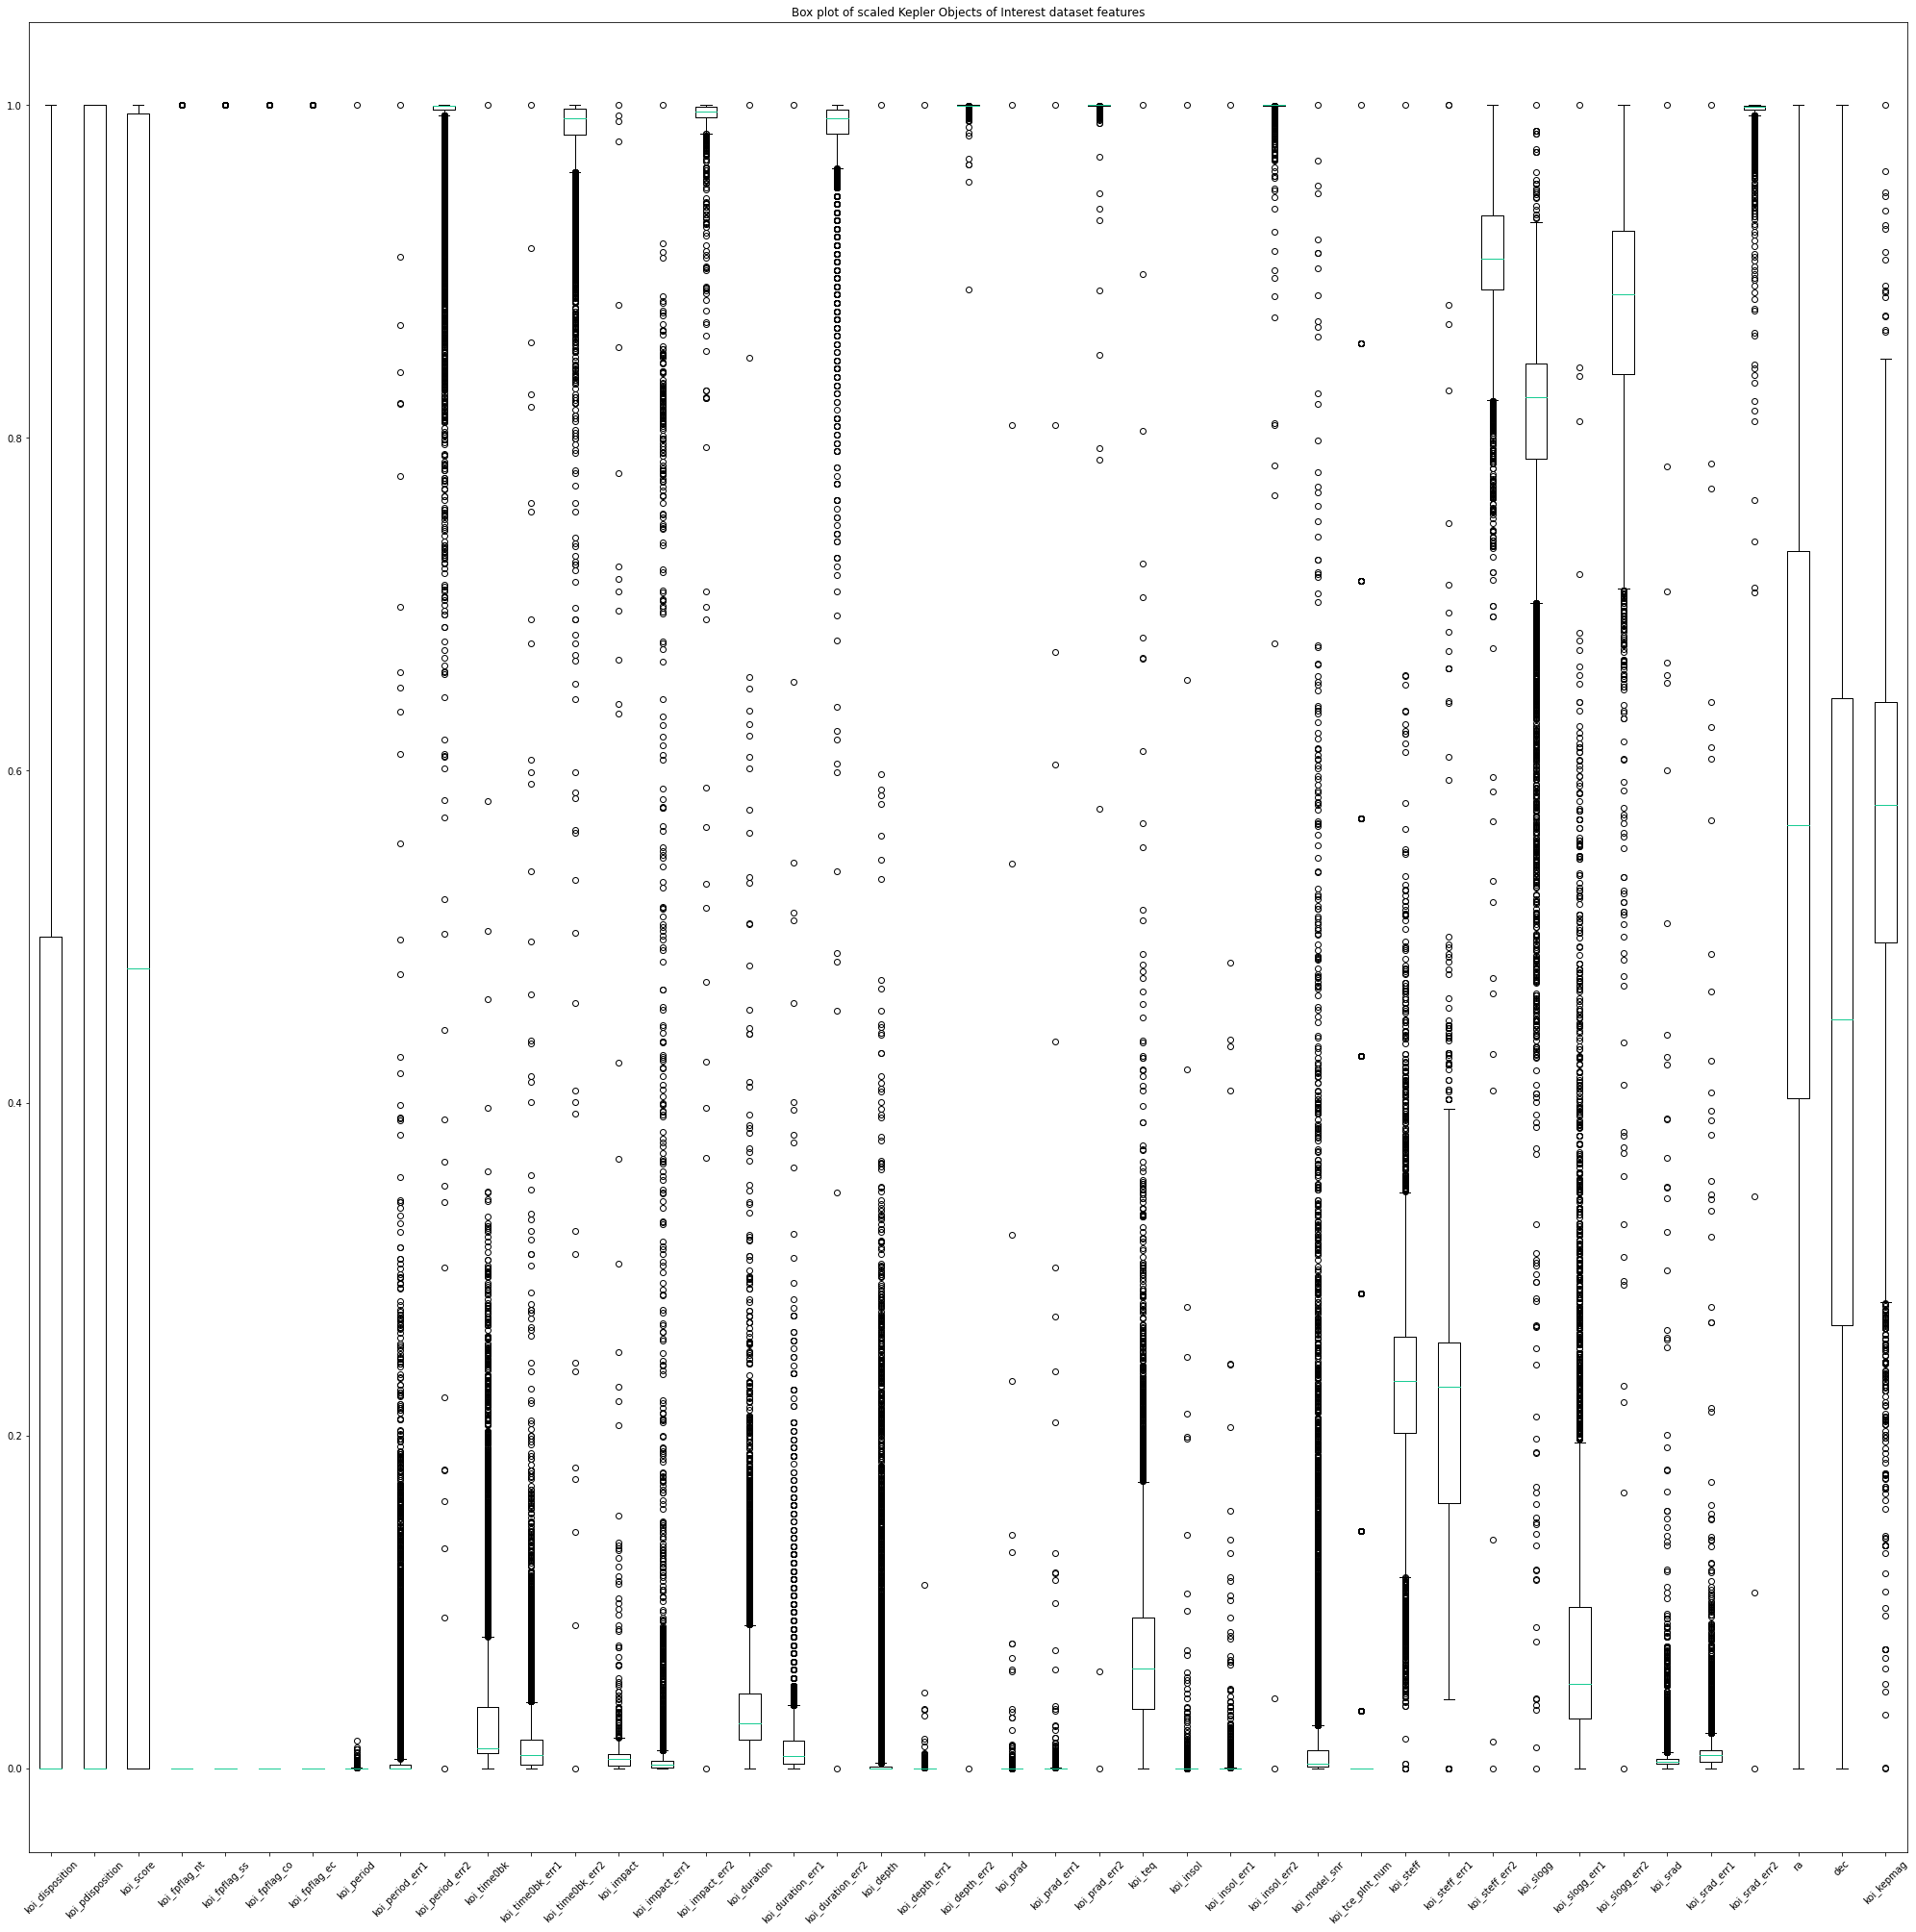

In [53]:
minmax = MinMaxScaler()
for column in data_scaled:

    data_scaled[column] = minmax.fit_transform(
        data_scaled[column].to_numpy().reshape(-1, 1))



fig = plt.figure(figsize=(35, 35))
plt.title("Box plot of scaled Kepler Objects of Interest dataset features")
plt.boxplot(data_scaled, labels=data_scaled.columns,
            medianprops=dict(color="#1ACC94"))
plt.xticks(rotation=45)
#plt.savefig('../data/figures/boxplot.png')
plt.show()


In [7]:
data = pd.read_csv('../data/cumulative.csv')
#data = pd.read_csv('../data/cumulative_2022.04.28_05.30.33.csv', header=53)
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(
    f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 'FALSE POSITIVE'])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 'CANDIDATE'])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 'CONFIRMED'])}")
print(
    f"Basis-Rate: {len(data.loc[data['koi_disposition'] == 0])/len(data['koi_disposition'])}")
data.head()

# Aber in Excel-Datei von Kaggle sind 2248 Kandidaten, 2294 bestätigte und 5023 falsch positive.
# Ich habe jedoch die Daten vom NASA Exoplanet Archive genommen. https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative


# Pop the columns:
# Spalten mit "id" oder "name" im Namen enthalten nur Bezeichnungen. Die beiden "koi_teq_err"-Spalten sind leer.
to_pop = ["kepid", "kepoi_name", "kepler_name", "koi_teq_err1",
          "koi_teq_err2", "koi_tce_delivname"]

for col in to_pop:
    data.pop(col)

# Numerische Werte:
koi_disposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2}
data["koi_disposition"] = data["koi_disposition"].replace(
    koi_disposition_dict)

koi_pdisposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1}
data["koi_pdisposition"] = data["koi_pdisposition"].replace(
    koi_pdisposition_dict)
data.head()



knn_imputer = KNNImputer()

for column in data:

    data[column] = knn_imputer.fit_transform(
        data[column].to_numpy().reshape(-1, 1))
        
        
# *_err*-Features zu entfernen verringert die Akkuranz
x = data.drop(['koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_ss', 'koi_fpflag_co',
               'koi_fpflag_ec', 'koi_fpflag_nt'], axis=1)
y = data["koi_disposition"].to_numpy().reshape(-1, 1)
type(x), type(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)#, random_state=45)

minmax = MinMaxScaler()
for column in x_train:

    if column == 'koi_disposition':
        pass
    else:
        x_train[column] = minmax.fit_transform(
            x_train[column].to_numpy().reshape(-1, 1))

        x_test[column] = minmax.fit_transform(
            x_test[column].to_numpy().reshape(-1, 1))

x_train.head()


Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 5023
Anzahl der Kandidaten-KOI: 2248
Anzahl der bestätigten KOI: 2293
Basis-Rate: 0.0


rowid  koi_period  koi_period_err1  koi_period_err2  koi_time0bk  \
6840  0.715227    0.000164         0.003290         0.996710     0.023529   
3496  0.365509    0.000017         0.000002         0.999998     0.018416   
8052  0.841979    0.000069         0.013698         0.986302     0.018553   
7747  0.810082    0.000003         0.000023         0.999977     0.014237   
3638  0.380360    0.000008         0.000054         0.999946     0.014674   

      koi_time0bk_err1  koi_time0bk_err2  koi_impact  koi_impact_err1  \
6840          0.031335          0.968665    0.001009         0.003909   
3496          0.000236          0.999764    0.007361         0.000549   
8052          0.020336          0.979664    0.007292         0.022912   
7747          0.009204          0.990796    0.007392         0.002060   
3638          0.012298          0.987702    0.007400         0.002572   

      koi_impact_err2  ...  koi_steff_err2  koi_slogg  koi_slogg_err1  \
6840         0.998286  ...        0.914302   0.823209        0.057745   
3496         0.997589  ...        0.946084   0.855746        0.010190   
8052         0.994394  ...        0.907909   0.801797        0.082023   
7747         0.991593  ...        0.864926   0.668798        0.388587   
3638         0.991571  ...        0.880817   0.832048        0.039402   

      koi_slogg_err2  koi_srad  koi_srad_err1  koi_srad_err2        ra  \
6840        0.789561  0.003864       0.017489       0.999018  0.812343   
3496        0.957746  0.002837       0.001791       0.999768  0.061369   
8052        0.881391  0.007048       0.017079       0.996601  0.812145   
7747        0.526098  0.012907       0.049121       0.984811  0.757366   
3638        0.856669  0.003873       0.011880       0.999070  0.700302   

           dec  koi_kepmag  
6840  0.749130    0.577050  
3496  0.690948    0.454783  
8052  0.642524    0.606581  
7747  0.377381    0.533482  
3638  0.643507    0.628826  

[5 rows x 37 columns]

In [10]:
# Optimisiertes Modell
best_point_svm = (2.8,6)
opt_svm = SVC(C=best_point_svm[0], kernel="linear",
              degree=best_point_svm[1], gamma="scale", probability=True)
fit_svm = opt_svm.fit(x_train, y_train)
predict_svm = opt_svm.predict(x_test)
y_proba_svm = opt_svm.predict_proba(x_test)
accuracy_svm = accuracy_score(y_test, predict_svm)
cm_svm = confusion_matrix(y_test, predict_svm)
#tn, fp, fn, tp = cm.ravel()

file_to_write = open("../data/models/svm_model.pickle", "wb")
pickle.dump(opt_svm, file_to_write)


print(f"Accuracy: {accuracy_svm}")
print(f"Confusion matrix: \n{cm_svm}")

#Diagonale: Richtige vorhersagen. Oben links: Anzahl der richtigen Vorhersagen des kleinsten Wertes.
#                                 Unten rechts: Anzahl der richtigen Vorhersagen des größten Wertes.
# 1. Zeile: False Positive. Links: Anzahl der richtigen Vorhersagen. Mitte: Anzahl der fälschlicherweise als 1
# vorhergesagten. Rechts: Anzahl der fälschlicherweise als 2 vorhergesagten.
# 2. Zeile: Candidate. Links: Anzahl der Anzahl der fälschlicherweise als 0 vorhergesagten. Rechts: Anzahl der
# fälschlicherweise als 2 vorhergesagten.
# 3. Zeile: Confirmed. Links: Wie in 2. Zeile. Mitte: Wie in 1. Zeile.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.6898954703832753
Confusion matrix: 
[[1436   34   31]
 [ 479   71  140]
 [ 175   31  473]]


In [11]:
opt_svm.coef_


array([[ 0.76339878, -1.14681666,  2.31804022, -2.31804022,  1.16862345,
        -0.58403216,  0.58403216,  3.70244731,  1.9850487 ,  3.28097899,
         4.06180767,  0.88070927, -0.88070927,  6.79550965,  0.4612235 ,
        -0.4612235 ,  0.14749188, -0.2147089 , -0.10766789,  9.59390226,
        -2.85240224, -2.96438236,  2.85934764,  9.33786742, -2.34380405,
        -3.81568364,  6.58776559, -5.31893966, -0.6636108 , -2.21443216,
        -1.35819752, -1.34075457, -0.26802928,  1.27196177,  0.44174495,
        -0.60850148, -0.93038787],
       [ 3.01011331,  0.22695914,  3.13655626, -3.13655626,  2.66706002,
         0.89464976, -0.89464976,  6.01754909,  7.64646163,  1.24429318,
         2.53892706,  6.96028345, -6.96028345,  7.35746431,  0.12498625,
        -0.12498625,  0.14168658,  0.24461734, -0.06235235, 14.06550303,
         0.14310401,  0.37374641, -0.07144247,  6.94030067, -2.20647293,
        -3.63571992,  6.78919285, -5.37990838, -0.08154352, -1.33683169,
        -1.56426